# Computing uncertainties from the strain rate fits. 

- load data
- compute profiles and velocities, $w$
- extract only $w$ in the region we want to fit
- fit with numpy, scipy, xarray
- examine the cross-correlation matrices we get from them 


In [1]:
%load_ext autoreload

%autoreload 2
import sys
sys.path.append("../../../xapres")
import xapres as xa
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
import xarray as xr

## Load the data and extract one chirp crop

### load

In [2]:
fd = xa.load.from_dats()
data_directory = '/Users/jkingslake/Documents/projects/current_projects/AntPen_NSF_NERC/AntPen_NSF_NERC/data/flask/ApRES Season1/7.12.2024_Site2_unattended/Data'
file_names = fd.list_files(data_directory)
len(file_names)


ds = xa.load.generate_xarray(data_directory, computeProfiles=False)
ds = ds.sortby('time').mean('chirp_num')
ds = ds.assign_coords({"time": ds.time- np.timedelta64(3, 'h')})
ds.time.attrs['long_name'] = 'time (PA time: UTC-3hrs)'
ds_c = ds.isel(time = slice(5,-1))
stacked = ds_c.addProfileToDs()
w = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 400, offset = 6)

In [3]:
w

<xarray.Dataset> Size: 248MB
Dimensions:                     (shot_number: 2, time: 88,
                                 attenuator_setting_pair: 2,
                                 profile_range: 39999, bin_depth: 1999)
Coordinates:
    filename                    (shot_number, time) <U23 16kB 'DATA2024-12-08...
    folder_name                 (time) <U4 1kB 'Data' 'Data' ... 'Data' 'Data'
    burst_number                (shot_number, time) int64 1kB 0 0 0 0 ... 0 0 0
    AFGain                      (time, attenuator_setting_pair) int64 1kB -4 ...
    attenuator                  (time, attenuator_setting_pair) float64 1kB 2...
    orientation                 (time) <U7 2kB 'unknown' 'unknown' ... 'unknown'
  * profile_range               (profile_range) float64 320kB 0.0 ... 8.411e+03
    profile_time                (shot_number, time) datetime64[ns] 1kB 2024-1...
  * time                        (time) datetime64[ns] 704B 2024-12-08T19:58:3...
  * shot_number                 (shot_number) int64 16B 1 2
  * bin_depth                   (bin_depth) float64 16kB 1.998 ... 8.405e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables: (12/14)
    profile                     (shot_number, time, attenuator_setting_pair, profile_range) complex128 225MB ...
    coherence                   (time, attenuator_setting_pair, bin_depth) complex128 6MB ...
    phase                       (time, attenuator_setting_pair, bin_depth) float64 3MB ...
    phase_variance              (time, attenuator_setting_pair, bin_depth) float64 3MB ...
    displacement                (time, attenuator_setting_pair, bin_depth) float64 3MB ...
    disp_variance               (time, attenuator_setting_pair, bin_depth) float64 3MB ...
    ...                          ...
    strain_rate                 (time, attenuator_setting_pair) float64 1kB 0...
    strain_rate_variance        (time, attenuator_setting_pair) float64 1kB 0...
    surface_intercept           (time, attenuator_setting_pair) float64 1kB -...
    surface_intercept_variance  (time, attenuator_setting_pair) float64 1kB 2...
    r_squared                   (time, attenuator_setting_pair) float64 1kB 0...
    sum_squared_residuals       (time, attenuator_setting_pair) float64 1kB 6...
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     20
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       6

### extract one chirp and crop

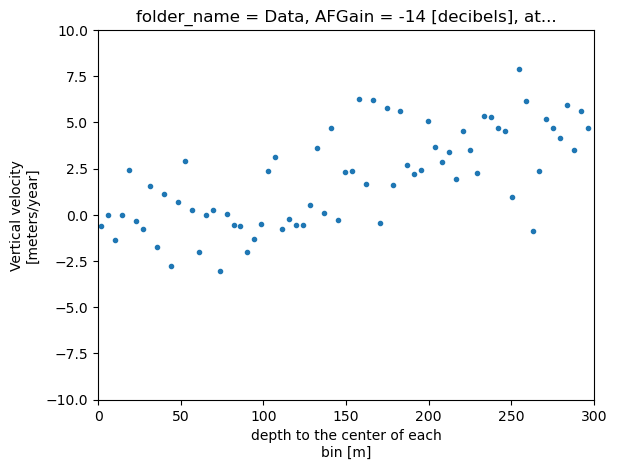

In [4]:
one_w = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0, 300))
xdata = one_w.bin_depth.values
ydata = one_w.velocity.values
sigma = ((one_w.velocity_variance)**0.5).values
one_w.velocity.plot(xlim=[0,300], ylim=[-10, 10], marker='.', linestyle = 'None')

<ErrorbarContainer object of 3 artists>

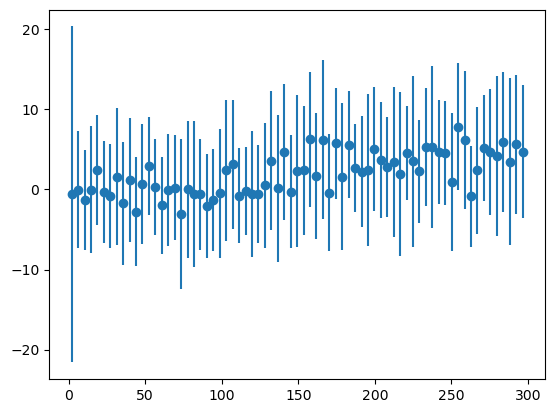

In [5]:
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

## Fit a linear model to the data
This is an estimate of vertical strain rates.

Do it with scipy (.curvefit), numpy (.polyfit), xarray (.polyfit), and via apply_ufunc (which uses numpy) and check we get the same answers. 

Also do the fit without weights, with relative weights, and with absolute weight. 

We should have 12 fits, each with two parameters each with uncertainties. 

### Create dataframe to store results

In [6]:
import pandas as pd
no_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])
rel_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])
abs_weights = pd.DataFrame(index=['slope', 'intercept', 'sigma_slope', 'sigma_intercept'], columns=['scipy', 'numpy', 'xarray', 'apply_ufunc'])


### Do the fits with scipy.curvefit

first define a linear function

In [7]:
def func(x, a, c):
    return a * x + c

In [10]:
# no weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata)
perr = np.sqrt(np.diag(pcov))
no_weights.scipy.slope = popt[0]
no_weights.scipy.intercept = popt[1]
no_weights.scipy.sigma_slope = perr[0]
no_weights.scipy.sigma_intercept = perr[1]

# relative weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=False)
perr = np.sqrt(np.diag(pcov))
rel_weights.scipy.slope = popt[0]
rel_weights.scipy.intercept = popt[1]
rel_weights.scipy.sigma_slope = perr[0]
rel_weights.scipy.sigma_intercept = perr[1]

# absolute weights
popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
abs_weights.scipy.slope = popt[0]
abs_weights.scipy.intercept = popt[1]
abs_weights.scipy.sigma_slope = perr[0]
abs_weights.scipy.sigma_intercept = perr[1]

abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020976,NaN,NaN,NaN
intercept,-1.266809,NaN,NaN,NaN
sigma_slope,0.010443,NaN,NaN,NaN
sigma_intercept,1.741211,NaN,NaN,NaN


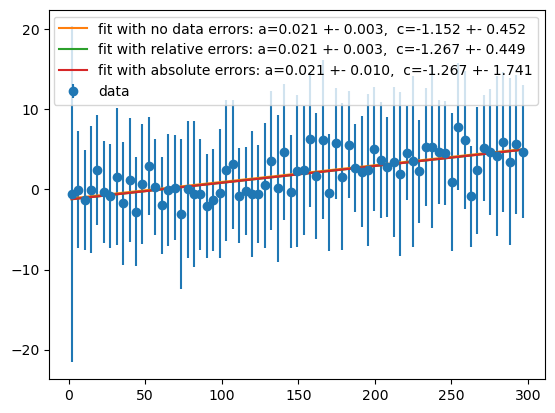

In [11]:
#popt, pcov = curve_fit(f = func, xdata=xdata, ydata=ydata)
#popt_sigma, pcov_sigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=False)
#popt_Abssigma, pcov_Abssigma = curve_fit(f = func, xdata=xdata, ydata=ydata, sigma=sigma, absolute_sigma=True)


plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

def param_str(df, method):
    return f'a={df[method].slope:5.3f} +- {df[method].sigma_slope:5.3f},  c={df[method].intercept:5.3f} +- {df[method].sigma_intercept:5.3f}'

plt.plot(xdata, func(xdata, no_weights.scipy.slope, no_weights.scipy.intercept),
         label=f"fit with no data errors: {param_str(no_weights, 'scipy')}")

plt.plot(xdata, func(xdata, rel_weights.scipy.slope, rel_weights.scipy.intercept),
            label=f"fit with relative errors: {param_str(rel_weights, 'scipy')}")

plt.plot(xdata, func(xdata, abs_weights.scipy.slope, abs_weights.scipy.intercept),
            label=f"fit with absolute errors: {param_str(abs_weights, 'scipy')}")
#perr = np.sqrt(np.diag(pcov_sigma))
#plt.plot(xdata, func(xdata, *popt_sigma),
#         label=f'fit with relative errors: a={popt_sigma[0]:5.3f}+- {perr[0]:5.3f},  c={popt_sigma[1]:5.3f} +- {perr[1]:5.3f}')

#perr = np.sqrt(np.diag(pcov_Abssigma))
#plt.plot(xdata, func(xdata, *popt_Abssigma),
#         label=f'fit with absolute errors: a={popt_Abssigma[0]:5.3f} +- {perr[0]:5.3f},  c={popt_Abssigma[1]:5.3f}+- {perr[1]:5.3f}')
plt.legend();

## Do the fit with numpy

In [13]:
popt, pcov = np.polyfit(xdata, ydata, 1, cov=True)
perr = np.sqrt(np.diag(pcov))
no_weights.numpy.slope = popt[0]
no_weights.numpy.intercept = popt[1]
no_weights.numpy.sigma_slope = perr[0]
no_weights.numpy.sigma_intercept = perr[1]

popt, pcov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov=True)
perr = np.sqrt(np.diag(pcov))
rel_weights.numpy.slope = popt[0]
rel_weights.numpy.intercept = popt[1]
rel_weights.numpy.sigma_slope = perr[0]
rel_weights.numpy.sigma_intercept = perr[1]

popt, pcov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov='unscaled')
perr = np.sqrt(np.diag(pcov))
abs_weights.numpy.slope = popt[0]
abs_weights.numpy.intercept = popt[1]
abs_weights.numpy.sigma_slope = perr[0]
abs_weights.numpy.sigma_intercept = perr[1]
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020976,0.020976,NaN,NaN
intercept,-1.266809,-1.266809,NaN,NaN
sigma_slope,0.010443,0.010443,NaN,NaN
sigma_intercept,1.741211,1.741211,NaN,NaN


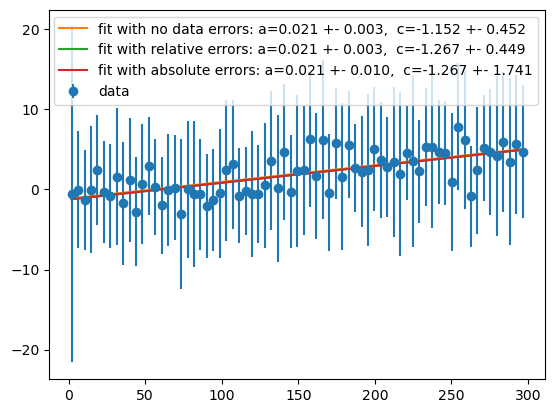

In [14]:
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')

plt.plot(xdata, func(xdata, no_weights.numpy.slope, no_weights.numpy.intercept),
         label=f"fit with no data errors: {param_str(no_weights, 'numpy')}")

plt.plot(xdata, func(xdata, rel_weights.numpy.slope, rel_weights.numpy.intercept),
            label=f"fit with relative errors: {param_str(rel_weights, 'numpy')}")

plt.plot(xdata, func(xdata, abs_weights.numpy.slope, abs_weights.numpy.intercept),
            label=f"fit with absolute errors: {param_str(abs_weights, 'numpy')}")
plt.legend();

## Do the fit with xarray

In [15]:
xarray_fit = one_w.velocity.polyfit('bin_depth', 1, cov = True)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
no_weights.xarray.slope = popt[0]
no_weights.xarray.intercept = popt[1]
no_weights.xarray.sigma_slope = perr[0]
no_weights.xarray.sigma_intercept = perr[1]

xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = True, w=1/sigma)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
rel_weights.xarray.slope = popt[0]
rel_weights.xarray.intercept = popt[1]
rel_weights.xarray.sigma_slope = perr[0]
rel_weights.xarray.sigma_intercept = perr[1]

xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = 'unscaled', w=1/sigma)
popt = [xarray_fit.sel(degree = 1).polyfit_coefficients.item(), xarray_fit.sel(degree = 0).polyfit_coefficients.item()]
perr = [np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[0], np.sqrt(np.diag(xarray_fit.polyfit_covariance.squeeze()))[1]]
abs_weights.xarray.slope = popt[0]
abs_weights.xarray.intercept = popt[1]
abs_weights.xarray.sigma_slope = perr[0]
abs_weights.xarray.sigma_intercept = perr[1]

In [16]:
xarray_fit = one_w.expand_dims(foo=1).velocity.polyfit(dim='bin_depth', deg= 1, cov = 'unscaled', w=1/sigma, full=True)
xarray_fit

<xarray.Dataset> Size: 104B
Dimensions:                    (degree: 2, foo: 1, cov_i: 2, cov_j: 2)
Coordinates:
  * degree                     (degree) int64 16B 1 0
  * foo                        (foo) int64 8B 0
Dimensions without coordinates: cov_i, cov_j
Data variables:
    bin_depth_matrix_rank      int64 8B 2
    bin_depth_singular_values  (degree) float64 16B 1.365 0.3716
    polyfit_coefficients       (degree, foo) float64 16B 0.02098 -1.267
    polyfit_residuals          (foo) float64 8B 4.592
    polyfit_covariance         (cov_i, cov_j) float64 32B 0.0001091 ... 3.032

## Implement it with ufuncs

We will need to use apply_ufunc because xarray's polyfit does not allow you to use a different vector of weights for each vector of w. 

In [17]:
import xarray as xr


#### no weights ---------------------------------

def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y, deg=deg, full=True)
        p, V = np.polyfit(x, y, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        input_core_dims=[["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(one_w, cov = 'full')

no_weights.apply_ufunc.slope = p.parameters[0].item()
no_weights.apply_ufunc.intercept = p.parameters[1].item()
no_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
no_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()


#### relative weights ---------------------------------

def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        (ds.velocity_variance)**0.5,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(one_w, cov = 'full')

rel_weights.apply_ufunc.slope = p.parameters[0].item()
rel_weights.apply_ufunc.intercept = p.parameters[1].item()
rel_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
rel_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()

#### absolute weights ---------------------------------

p = polyfit(one_w, cov = 'unscaled')

abs_weights.apply_ufunc.slope = p.parameters[0].item()
abs_weights.apply_ufunc.intercept = p.parameters[1].item()
abs_weights.apply_ufunc.sigma_slope = p.parameter_uncertainty[0].item()
abs_weights.apply_ufunc.sigma_intercept = p.parameter_uncertainty[1].item()
abs_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020976,0.020976,0.020976,0.020976
intercept,-1.266809,-1.266809,-1.266809,-1.266809
sigma_slope,0.010443,0.010443,0.010443,0.010443
sigma_intercept,1.741211,1.741211,1.741211,1.741211


### test that all three methods agree
Loop through the dataframes and for each one loop through the parameters and their uncertainties (the rows) and check that values are close to each other across the methods (the columns)

In [18]:
no_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020883,0.020883,0.020883,0.020883
intercept,-1.152491,-1.152491,-1.152491,-1.152491
sigma_slope,0.002623,0.002623,0.002623,0.002623
sigma_intercept,0.45204,0.45204,0.45204,0.45204


In [19]:
for i, df in enumerate([no_weights, rel_weights, abs_weights]):
    print(i)
    for row in df.index:
        print(row)
        l = list(df.loc[row])
        assert (np.all(l - l[0] < 1e-7))

0
slope
intercept
sigma_slope
sigma_intercept
1
slope
intercept
sigma_slope
sigma_intercept
2
slope
intercept
sigma_slope
sigma_intercept


In [20]:
no_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020883,0.020883,0.020883,0.020883
intercept,-1.152491,-1.152491,-1.152491,-1.152491
sigma_slope,0.002623,0.002623,0.002623,0.002623
sigma_intercept,0.45204,0.45204,0.45204,0.45204


In [21]:
rel_weights

,scipy,numpy,xarray,apply_ufunc
slope,0.020976,0.020976,0.020976,0.020976
intercept,-1.266809,-1.266809,-1.266809,-1.266809
sigma_slope,0.002694,0.002694,0.002694,0.002694
sigma_intercept,0.449191,0.449191,0.449191,0.449191


In [22]:
abs_weights 

,scipy,numpy,xarray,apply_ufunc
slope,0.020976,0.020976,0.020976,0.020976
intercept,-1.266809,-1.266809,-1.266809,-1.266809
sigma_slope,0.010443,0.010443,0.010443,0.010443
sigma_intercept,1.741211,1.741211,1.741211,1.741211


### test the apply_ufunc method with higher dimension data

In [23]:
two_w = w.isel(attenuator_setting_pair=1, time=slice(60, 62)).sel(bin_depth=slice(0,300))
w_60 = w.isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0,300))
w_61 = w.isel(attenuator_setting_pair=1, time=61).sel(bin_depth=slice(0,300))

In [24]:
def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        (ds.velocity_variance)**0.5,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(two_w)
p

<xarray.Dataset> Size: 216B
Dimensions:                (time: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 32B 'Data' 'Data'
    AFGain                 (time) int64 16B -14 -14
    attenuator             (time) float64 16B 10.0 10.0
    orientation            (time) <U7 56B 'unknown' 'unknown'
  * time                   (time) datetime64[ns] 16B 2024-12-11T07:01:48 2024...
Dimensions without coordinates: degree
Data variables:
    parameters             (time, degree) float64 32B 0.02098 -1.267 ... -12.31
    parameter_uncertainty  (time, degree) float64 32B 0.01044 1.741 0.01508 2.57
    polyfit_residuals      (time) float64 16B 4.592 6.114

### Recording the residuals
(Also check that the weights are getting broadcast correctly. )

Do this by computing the fit on a dataset with two time slices and compute it on each time slice separately and check that the results are the same.

In [25]:
def polyfit(ds, deg = 1, cov = 'unscaled'):
    # Define a slim wrapper around np.polyfit
    def my_polyfit(x, y, sigma, cov, deg=1):
        p, residuals,  rank, singular_values, rcond = np.polyfit(x, y,  w=1/sigma, deg=deg, full=True)
        p, V = np.polyfit(x, y,  w=1/sigma, deg=deg, cov=cov)
        perr = np.sqrt(np.diag(V))
        return p, perr, residuals

    res = xr.apply_ufunc(
        my_polyfit,
        ds.bin_depth,
        ds.velocity,
        (ds.velocity_variance)**0.5,
        input_core_dims=[["bin_depth"], ["bin_depth"], ["bin_depth"]],
        output_core_dims=[["degree"], ["degree"], ["dummy_dim"]],
        kwargs = {'deg': deg, 'cov': cov},
        vectorize=True            
    )
    out = [res[0].rename("parameters"), res[1].rename("parameter_uncertainty") , res[2].squeeze().rename("polyfit_residuals")]
    return xr.merge(out)

p = polyfit(two_w)
p

<xarray.Dataset> Size: 216B
Dimensions:                (time: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 32B 'Data' 'Data'
    AFGain                 (time) int64 16B -14 -14
    attenuator             (time) float64 16B 10.0 10.0
    orientation            (time) <U7 56B 'unknown' 'unknown'
  * time                   (time) datetime64[ns] 16B 2024-12-11T07:01:48 2024...
Dimensions without coordinates: degree
Data variables:
    parameters             (time, degree) float64 32B 0.02098 -1.267 ... -12.31
    parameter_uncertainty  (time, degree) float64 32B 0.01044 1.741 0.01508 2.57
    polyfit_residuals      (time) float64 16B 4.592 6.114

In [26]:
assert (polyfit(two_w).parameters.isel(time=0) == polyfit(w_60).parameters).all()
assert (polyfit(two_w).parameters.isel(time=1) == polyfit(w_61).parameters).all()

assert (polyfit(two_w).parameter_uncertainty.isel(time=0) == polyfit(w_60).parameter_uncertainty).all()
assert (polyfit(two_w).parameter_uncertainty.isel(time=1) == polyfit(w_61).parameter_uncertainty).all()

## Try out the new approach with a different cropping methods. 
.where()
vs
.sel()

In [27]:
#velocity_cropped = w.velocity.where( (w.bin_depth < 300) & (w.bin_depth > 20))
velocity_cropped = w.sel(bin_depth = slice(20, 301))

polyfit(velocity_cropped)

<xarray.Dataset> Size: 14kB
Dimensions:                (time: 88, attenuator_setting_pair: 2, degree: 2)
Coordinates:
    folder_name            (time) <U4 1kB 'Data' 'Data' 'Data' ... 'Data' 'Data'
    AFGain                 (time, attenuator_setting_pair) int64 1kB -4 ... -14
    attenuator             (time, attenuator_setting_pair) float64 1kB 20.0 ....
    orientation            (time) <U7 2kB 'unknown' 'unknown' ... 'unknown'
  * time                   (time) datetime64[ns] 704B 2024-12-08T19:58:36.500...
Dimensions without coordinates: attenuator_setting_pair, degree
Data variables:
    parameters             (time, attenuator_setting_pair, degree) float64 3kB ...
    parameter_uncertainty  (time, attenuator_setting_pair, degree) float64 3kB ...
    polyfit_residuals      (time, attenuator_setting_pair) float64 1kB 24.19 ...

0.012942004132423078

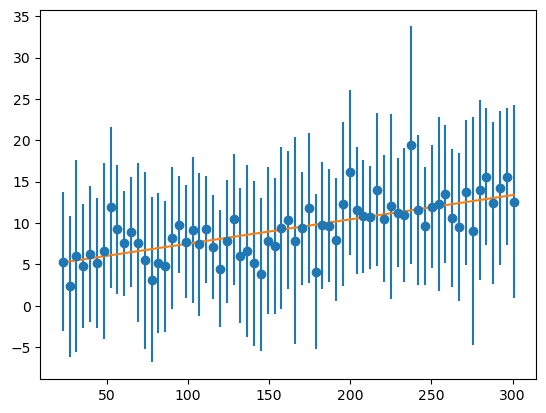

In [28]:
w1 = velocity_cropped.isel(time=30, attenuator_setting_pair=0)
plt.errorbar(x=w1.bin_depth, y=w1.velocity, yerr=(w1.velocity_variance)**0.5, marker='o', label='data', linestyle='None')
plt.plot(w1.bin_depth, np.polyval(polyfit(w1).parameters.values, w1.bin_depth), label='fit')

polyfit(w1).parameter_uncertainty.sel(degree=0).item()

`.sel` seems like a faster option that `.where`. 

## Testing the new implementation in utils.py

In [29]:
from_utils = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 300, offset = 6)
from_utils_1_cropped = stacked.profile.displacement_timeseries(max_depth_for_ezz_fit = 300, offset = 6).isel(attenuator_setting_pair=1, time=60).sel(bin_depth=slice(0, 300))
from_utils_1_cropped

<xarray.Dataset> Size: 2MB
Dimensions:                     (shot_number: 2, profile_range: 39999,
                                 bin_depth: 71)
Coordinates:
    filename                    (shot_number) <U23 184B 'DATA2024-12-11-0701....
    folder_name                 <U4 16B 'Data'
    burst_number                (shot_number) int64 16B 0 0
    AFGain                      int64 8B -14
    attenuator                  float64 8B 10.0
    orientation                 <U7 28B 'unknown'
  * profile_range               (profile_range) float64 320kB 0.0 ... 8.411e+03
    profile_time                (shot_number) datetime64[ns] 16B 2024-12-11T0...
    time                        datetime64[ns] 8B 2024-12-11T07:01:48
  * shot_number                 (shot_number) int64 16B 1 2
  * bin_depth                   (bin_depth) float64 568B 1.998 6.204 ... 296.4
Data variables: (12/14)
    profile                     (shot_number, profile_range) complex128 1MB (...
    coherence                   (bin_depth) complex128 1kB (0.868568454222051...
    phase                       (bin_depth) float64 568B -0.009667 ... 0.07216
    phase_variance              (bin_depth) float64 568B 0.1038 ... 0.01625
    displacement                (bin_depth) float64 568B -0.0004314 ... 0.00322
    disp_variance               (bin_depth) float64 568B 0.0002068 ... 3.237e-05
    ...                          ...
    strain_rate                 float64 8B 0.02098
    strain_rate_variance        float64 8B 0.0001091
    surface_intercept           float64 8B -1.267
    surface_intercept_variance  float64 8B 3.032
    r_squared                   float64 8B 0.4677
    sum_squared_residuals       float64 8B 4.592
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     20
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       6

In [35]:
# add new column to dataframe
abs_weights['xa_utils'] = abs_weights.numpy*np.nan
# add values from from_utils xarray to the df in the final column
abs_weights.loc['slope', 'xa_utils'] = from_utils_1_cropped.strain_rate.item()
abs_weights.loc['intercept', 'xa_utils'] = from_utils_1_cropped.surface_intercept.item()
abs_weights.loc['sigma_slope', 'xa_utils'] = from_utils_1_cropped.strain_rate_variance.item()**0.5
abs_weights.loc['sigma_intercept', 'xa_utils'] = from_utils_1_cropped.surface_intercept_variance.item()**0.5
abs_weights

,scipy,numpy,xarray,apply_ufunc,xa_utils
slope,0.020976,0.020976,0.020976,0.020976,0.020976
intercept,-1.266809,-1.266809,-1.266809,-1.266809,-1.266809
sigma_slope,0.010443,0.010443,0.010443,0.010443,0.010443
sigma_intercept,1.741211,1.741211,1.741211,1.741211,1.741211


## compute residuals after computation 
This will allow me to avoid calling polyfit twice in the apply_ufunc function in untils.py.


In [36]:
# compute residuals with polyfit paramaers
def compute_residuals_unweighted(ds):
    #sum of squared residuals of the least squares fit#
    residuals = ds.velocity - (ds.strain_rate * ds.bin_depth + ds.surface_intercept)
    return (residuals**2).sum(dim='bin_depth')

compute_residuals_unweighted(from_utils_1_cropped)


<xarray.DataArray ()> Size: 8B
array(251.2135196)
Coordinates:
    folder_name  <U4 16B 'Data'
    AFGain       int64 8B -14
    attenuator   float64 8B 10.0
    orientation  <U7 28B 'unknown'
    time         datetime64[ns] 8B 2024-12-11T07:01:48

In [38]:
# compute residuals with polyfit paramaters
def compute_residuals_weighted(ds):
    # weighted sum of squared residuals of the least squares fit
    residuals = ds.velocity - (ds.strain_rate * ds.bin_depth + ds.surface_intercept)
    return (residuals**2).weighted(1/ds.velocity_variance).sum(dim='bin_depth')

compute_residuals_weighted(from_utils_1_cropped)

<xarray.DataArray ()> Size: 8B
array(4.59207642)
Coordinates:
    folder_name  <U4 16B 'Data'
    AFGain       int64 8B -14
    attenuator   float64 8B 10.0
    orientation  <U7 28B 'unknown'
    time         datetime64[ns] 8B 2024-12-11T07:01:48

It looks like polyfit returns a weighted sum of square residuals.

In [39]:
p, residuals,  rank, singular_values, rcond = np.polyfit(from_utils_1_cropped.bin_depth.values, 
                                                         from_utils_1_cropped.velocity.values, 
                                                         deg=1, 
                                                         w=1/(from_utils_1_cropped.velocity_variance**0.5).values, 
                                                         full=True)
assert np.allclose(residuals, compute_residuals_weighted(from_utils_1_cropped))
assert np.allclose(residuals, from_utils_1_cropped.sum_squared_residuals)

The following are all the same, as required:
1. The residauls from the function `compute_residuals_weighted` defined above
2. The residuals from calling polyfit with weights, called above, and 
3. The residuals from the calling xa.utils.computeStrainRates via calling displacement_timeseries above

## Compute a weighted R2

In [40]:
 # R^2
def r2(ds):

    residuals = ds.velocity - (ds.strain_rate * ds.bin_depth + ds.surface_intercept)
    sum_of_square_residuals = (residuals**2).sum(dim='bin_depth')

    y_mean = ds.velocity.mean(dim = 'bin_depth')
    SS_tot = ((ds.velocity - y_mean)**2).sum(dim = 'bin_depth')
    return  (1 - (sum_of_square_residuals/SS_tot)).rename('r_squared')
r2(from_utils_1_cropped)

<xarray.DataArray 'r_squared' ()> Size: 8B
array(0.477205)
Coordinates:
    folder_name  <U4 16B 'Data'
    AFGain       int64 8B -14
    attenuator   float64 8B 10.0
    orientation  <U7 28B 'unknown'
    time         datetime64[ns] 8B 2024-12-11T07:01:48

In [41]:
 # R^2
def r2_weighted(ds):

    sum_of_square_residuals = compute_residuals_weighted(ds)
    y_mean = ds.velocity.weighted(1/ds.velocity_variance).mean(dim = 'bin_depth')
    SS_tot = ((ds.velocity - y_mean)**2).weighted(1/ds.velocity_variance).sum(dim = 'bin_depth')
    return  (1 - (sum_of_square_residuals/SS_tot)).rename('r_squared')
assert np.allclose(r2_weighted(from_utils_1_cropped), from_utils_1_cropped.r_squared)

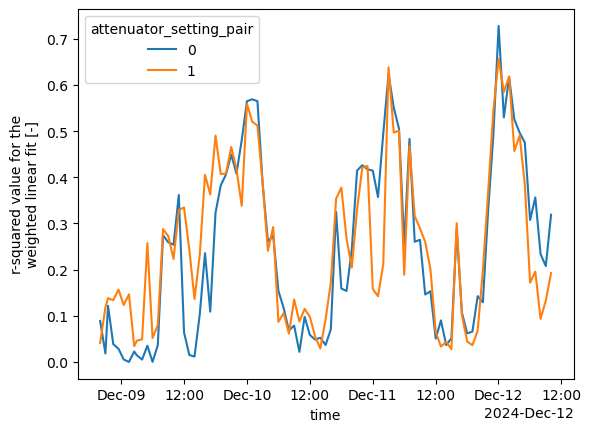

In [42]:
from_utils.r_squared.plot.line(x='time')

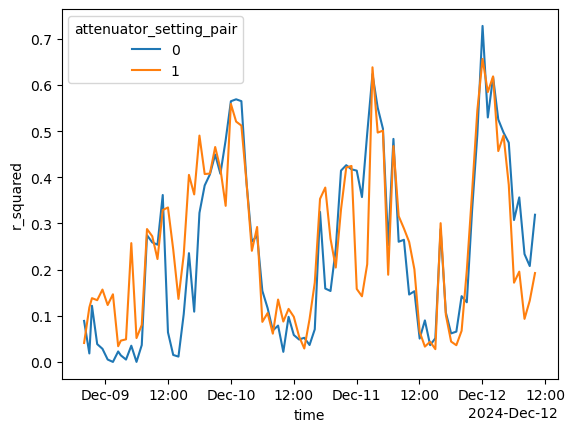

In [43]:
r2_weighted(from_utils.sel(bin_depth=slice(0,300))).plot.line(x='time')

The r2 computed with the function `r2_weighted` defined above is the same as the r2 computed in xa.utils.weighted_least_squares, as required.

## A test for the weighted fit and for the r2 values

In [46]:
ds = xa.load.generate_xarray('../../data/sample/multi-burst-dat-file/').mean('chirp_num')

ds_1_cropped = ds.profile.displacement_timeseries(max_depth_for_ezz_fit = 300, offset = 6).isel(attenuator_setting_pair=1, time=4).sel(bin_depth=slice(0, 300))

xdata = ds_1_cropped.bin_depth.values
ydata = ds_1_cropped.velocity.values
sigma = ((ds_1_cropped.velocity_variance)**0.5).values

popt, pcov = np.polyfit(xdata, ydata, 1, w=1/sigma, cov='unscaled')
perr = np.sqrt(np.diag(pcov))
slope = popt[0]
intercept = popt[1]
slope_sigma = perr[0]
intercept_sigma = perr[1]

assert np.allclose(slope, ds_1_cropped.strain_rate.item())
assert np.allclose(intercept, ds_1_cropped.surface_intercept.item())
assert np.allclose(slope_sigma, ds_1_cropped.strain_rate_variance.item()**0.5)
assert np.allclose(intercept_sigma, ds_1_cropped.surface_intercept_variance.item()**0.5)

def compute_residuals_weighted(ds):
    # weighted sum of squared residuals of the least squares fit
    residuals = ds.velocity - (ds.strain_rate * ds.bin_depth + ds.surface_intercept)
    return (residuals**2).weighted(1/ds.velocity_variance).sum(dim='bin_depth')

def r2_weighted(ds):
    sum_of_square_residuals = compute_residuals_weighted(ds)
    y_mean = ds.velocity.weighted(1/ds.velocity_variance).mean(dim = 'bin_depth')
    SS_tot = ((ds.velocity - y_mean)**2).weighted(1/ds.velocity_variance).sum(dim = 'bin_depth')
    return  (1 - (sum_of_square_residuals/SS_tot)).rename('r_squared')
assert np.allclose(r2_weighted(ds_1_cropped), ds_1_cropped.r_squared)

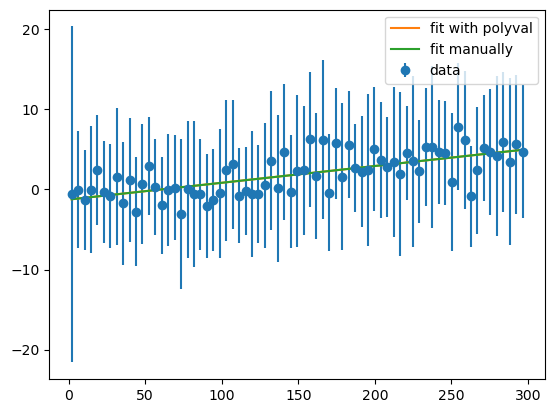

In [47]:
#one_w.velocity.plot(label = 'data', marker='.', linestyle = 'None')
plt.errorbar(x=from_utils_1_cropped.bin_depth, y=from_utils_1_cropped.velocity, yerr=from_utils_1_cropped.velocity_variance**0.5, marker='o', label='data', linestyle='None')
plt.plot(from_utils_1_cropped.bin_depth, np.polyval((from_utils_1_cropped.strain_rate, from_utils_1_cropped.surface_intercept), one_w.bin_depth), label='fit with polyval')
plt.plot(from_utils_1_cropped.bin_depth, from_utils_1_cropped.strain_rate * from_utils_1_cropped.bin_depth + from_utils_1_cropped.surface_intercept, label='fit manually')
plt.legend()

## Trying statsmodels to plot confidence intervals

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
df['year'] = df['year'].astype(float)
X = sm.add_constant(df['year'].values)
ols_model = sm.OLS(df['count'].values, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
df.plot(x='year',y='count',linestyle='None',marker='s', ax=ax)
y_pred = est.predict(X)
x_pred = df.year.values
ax.plot(x_pred,y_pred)

pred = est.get_prediction(X).summary_frame()
ax.plot(x_pred,pred['mean_ci_lower'],linestyle='--',color='blue')
ax.plot(x_pred,pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')



In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#df = pd.DataFrame({'year':['1990','1991','1992','1993','1994','1995','1996','1997','1998','1999','2000'],
#                   'count':[96,184,148,154,160,149,124,274,322,301,300]})
#df['year'] = df['year'].astype(float)
X = sm.add_constant(xdata)
ols_model = sm.OLS(ydata, X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
plt.errorbar(x=xdata, y=ydata, yerr=sigma, marker='o', label='data', linestyle='None')
y_pred = est.predict(X)
x_pred = xdata
ax.plot(x_pred, y_pred)

pred = est.get_prediction(X).summary_frame()
ax.plot(x_pred, pred['mean_ci_lower'],linestyle='--',color='blue')
ax.plot(x_pred, pred['mean_ci_upper'],linestyle='--',color='blue')

# Alternative way to plot
def line(x,b=0,m=1):
    return m*x+b

ax.plot(x_pred,line(x_pred,est.params[0],est.params[1]),color='blue')



In [ ]:
dir(est)

In [ ]:
print(est.summary())

In [ ]:
est.get_prediction(X).summary_frame()